In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf

## EDA

### Additional Variables Used
- #### Log Returns: 
    - $\ln(\frac{Current Price}{Original Price})$
    - Log returns measure the percentage change in value over time. This allows us to have a good gauge of the general direction of price.
- #### Index Funds
    - Index funds can be used as indicators of industry performance. For this case, the SMA20 of [SPDR Technology Sector Fund (XLK)](https://finance.yahoo.com/quote/XLK?p=XLK) is used as a gauge for the performance of the tech industry as a whole.


In [30]:
# Fetch data from Yahoo Finance
df = yf.download(tickers='NVDA', start='2015-01-01')
df_xlk = yf.download(tickers='XLK', start='2015-01-01')

# Check if data has same shape
df.shape, df_xlk.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((2216, 6), (2216, 6))

In [3]:
#df.head()
df_xlk.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,168.910004,171.020004,168.880005,170.250000,170.250000,7272100
2023-10-17,168.110001,170.339996,166.899994,169.460007,169.460007,7658900
2023-10-18,168.270004,169.639999,167.029999,167.720001,167.720001,6431400
2023-10-19,168.389999,169.520004,166.470001,166.759995,166.759995,9995900
2023-10-20,166.679993,166.800003,163.770004,163.940002,163.940002,7667700


In [31]:
# Calculate SMA20 for NVDA
df['SMA20'] = df['Adj Close'].rolling(20).mean()

# Calculate SMA20 for XLK
df['xlk_SMA20'] = df_xlk['Adj Close'].rolling(20).mean()

# Calculate log return
df['log_return'] = np.log(1 + df['Adj Close'].pct_change())


Text(0.5, 1.0, 'NVDA vs XLK Price')

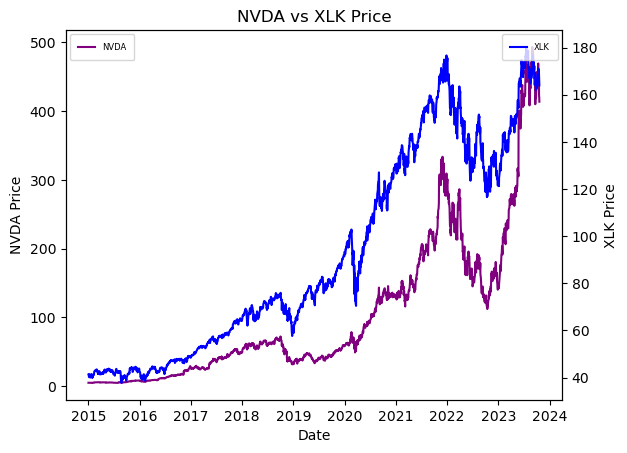

In [4]:
# Finding correlation between NVDA and XLK ETF
fig, ax = plt.subplots()
ax.plot(df['Close'], color='purple', label='NVDA')
ax.set_xlabel('Date')
ax.set_ylabel('NVDA Price')
ax.legend(loc='upper left', borderpad=1, fontsize=6)

ax2 = ax.twinx()
ax2.plot(df_xlk['Close'], color='blue', label='XLK')
ax2.set_ylabel('XLK Price')
ax2.legend(loc='upper right', borderpad=1, fontsize=6)
plt.title('NVDA vs XLK Price')

## Prepare Data

In [5]:
# GLOBAL VARS
NUM_VARS = 7 #8 Trying without log return
TIMESTEPS = 30 #10
DAYS_TO_PRED = 10
ADJ_CLOSE_INDEX = 3

In [32]:
# Drop unwanted columns
df.dropna(inplace=True)
#df.reset_index(inplace=True)
df.drop(['Close', 'log_return'], axis=1, inplace=True)

# Assign a backup df for accessing later
backup_df = df[TIMESTEPS:]

In [33]:
# Define function to split data
def split(dataset):
    
    # DAYS_TO_PRED rows will be removed for test data, remaining split .8 .2
    test_val_len = len(dataset) - DAYS_TO_PRED
    l_80 = int(test_val_len * 0.8)
    train_data, val_data, test_data = dataset[: l_80], dataset[l_80 : test_val_len], dataset[test_val_len :]
    return train_data, val_data, test_data

In [34]:
# Define function to create dataset with timesteps
def create_dataset(dataset, timesteps):

    x = []
    y = []
    
    for i in range(len(dataset) - timesteps):
        '''
        for e.g. timesteps = 20
        [add_x] --> [add_y]:
        for one var:
        [0, 1, 2, ... 20] --> [21]
        [1, 2, 3, ... 21] --> [22]

        for multiple vars:
        [[a1, b1, c1], [a2, b2, c2], [a3, b3, c3], ... [a20, b20, c20]] --> [a21, b21, c21]
        '''
        add_x = dataset[i : i + timesteps] # At i = 0, slice from 0 - timesteps
        add_y = dataset[i + timesteps]

        # Extract vars
        add_x = [lst for lst in add_x]

        x.append(add_x)
        y.append(add_y)
    return np.array(x), np.array(y)

In [35]:
# Normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Create datasets
X_full, y_full = create_dataset(df, TIMESTEPS)

# Split data
X_train, X_val, X_test = split(X_full)
y_train, y_val, y_test = split(y_full)

# Shape should be (samples, timesteps, features)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1725, 30, 7), (1725, 7), (432, 30, 7), (432, 7), (10, 30, 7), (10, 7))

In [36]:
# Check if values are correct
X_train[1][-1] == y_train[0]

array([ True,  True,  True,  True,  True,  True,  True])

## Stacked LSTM Implementation
LSTMs are a type of RNN that remember information over long periods of time, which allows us to work with non-stationary data. LSTMs are also able to pick up on patterns from large datasets, making them better suited for predicting stock prices. 

In [37]:
# GLOBAL VARS
EPOCHS = 10 #15
INPUT_SHAPE = (TIMESTEPS, NUM_VARS)
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 64

In [12]:
# Define model
model = keras.Sequential([

    keras.layers.LSTM(64, return_sequences=True, input_shape=INPUT_SHAPE, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(64, return_sequences=True, activation='relu'),    
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(NUM_VARS, activation='linear')
    
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

2023-10-23 09:54:47.408587: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-23 09:54:47.408612: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-23 09:54:47.408619: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-23 09:54:47.408798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-23 09:54:47.408816: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            18432     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_2 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            4

In [13]:
# Train model
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/10


2023-10-23 09:54:49.582287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 188s 7s/step - loss: 0.0186 - accuracy: 0.5328 - val_loss: 0.0300 - val_accuracy: 0.9329
Epoch 2/10
27/27 [==============================] - 171s 6s/step - loss: 0.0035 - accuracy: 0.8446 - val_loss: 0.0168 - val_accuracy: 0.9398
Epoch 3/10
27/27 [==============================] - 173s 6s/step - loss: 0.0025 - accuracy: 0.9072 - val_loss: 0.0102 - val_accuracy: 0.9398
Epoch 4/10
27/27 [==============================] - 183s 7s/step - loss: 0.0021 - accuracy: 0.9165 - val_loss: 0.0113 - val_accuracy: 0.9398
Epoch 5/10
27/27 [==============================] - 173s 6s/step - loss: 0.0020 - accuracy: 0.9252 - val_loss: 0.0097 - val_accuracy: 0.9398
Epoch 6/10
27/27 [==============================] - 130s 5s/step - loss: 0.0019 - accuracy: 0.9322 - val_loss: 0.0124 - val_accuracy: 0.9398
Epoch 7/10
27/27 [==============================] - 118s 4s/step - loss: 0.0018 - accuracy: 0.9275 - val_loss: 0.0078 - val_accuracy: 0.9398
Epoch 8/10
27/27 [======

## Model Evaluation

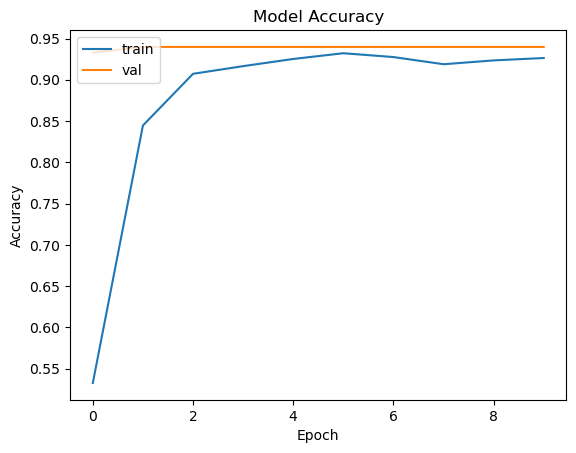

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

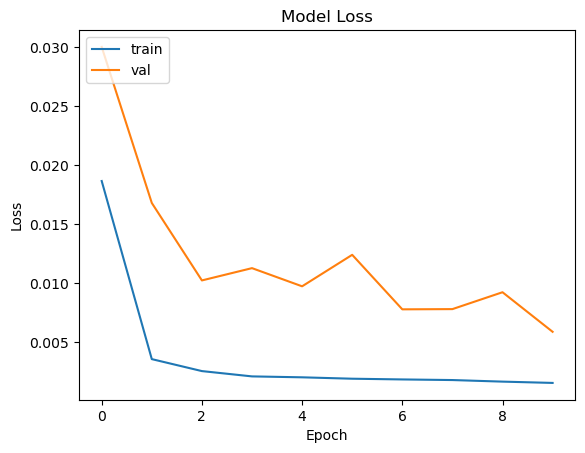

In [15]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

### Check Predictions on Existing Data

In [16]:
# Prediction on test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get original format
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

1/1 [==============================] - 1s 556ms/step


In [17]:
# Extract Adj Close Col
train_predict = [rows[ADJ_CLOSE_INDEX] for rows in train_predict]
y_train = [rows[ADJ_CLOSE_INDEX] for rows in y_train]

test_predict = [rows[ADJ_CLOSE_INDEX] for rows in test_predict]
y_test = [rows[ADJ_CLOSE_INDEX] for rows in y_test]

In [18]:
train_results = pd.DataFrame(data={'Predictions': train_predict, 'Actual': y_train})
test_results = pd.DataFrame(data={'Predictions': test_predict, 'Actual': y_test})

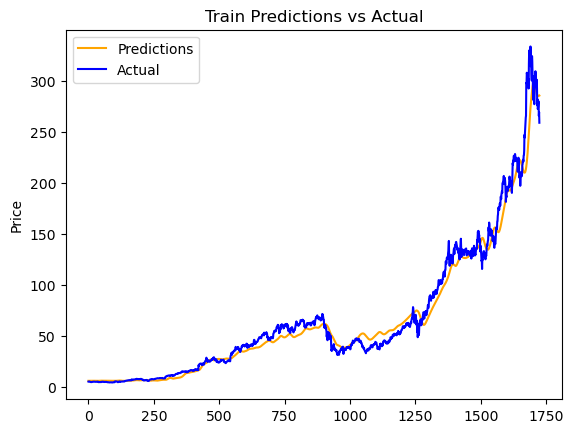

In [19]:
plt.plot(train_results['Predictions'], color='orange')
plt.plot(train_results['Actual'], color='blue')
plt.title('Train Predictions vs Actual')
plt.ylabel('Price')
plt.legend(['Predictions', 'Actual'], loc='upper left')

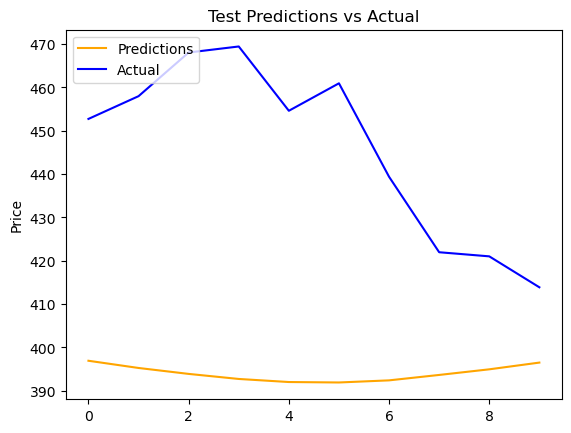

In [20]:
plt.plot(test_results['Predictions'], color='orange')
plt.plot(test_results['Actual'], color='blue')
plt.title('Test Predictions vs Actual')
plt.ylabel('Price')
plt.legend(['Predictions', 'Actual'], loc='upper left')

In [21]:
# Define Function to calculate rmse
def calc_rmse(actual, prediction):
    return mean_squared_error(actual, prediction, squared=False)

In [22]:
print(
    'Train RMSE:', calc_rmse(y_train, train_predict),'\n'
    'Test RMSE:', calc_rmse(y_test, test_predict)
    )

Train RMSE: 11.388807517232351 
Test RMSE: 55.78843194158881


### Make Predictions

In [38]:
# Define function to predict
def get_predictions(days, dataset):
    
    predictions = []

    # Select the last row which contains past TIMESTEPS rows of data.
    dataset = dataset[-1]
    
    for i in range(days):
        
        # Reshape data for prediction input
        dataset = np.reshape(dataset, (1, TIMESTEPS, NUM_VARS))

        prediction = model.predict(dataset)
        predictions.append(prediction)

        # Remove first day from window
        dataset = dataset[0][1:]

        # Add back to prediction input
        dataset = np.concatenate([dataset, prediction], axis=0)
    
    predictions = scaler.inverse_transform(dataset)
    predictions = pd.DataFrame(predictions)[-days:]
    return predictions


In [39]:
final_pred = get_predictions(DAYS_TO_PRED, X_test)

1/1 [==============================] - 0s 379ms/step


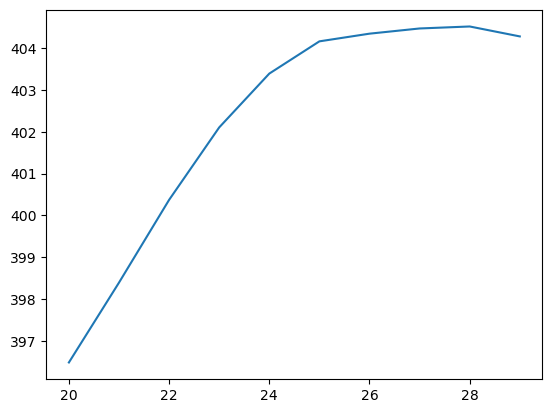

In [40]:
plt.plot(final_pred[ADJ_CLOSE_INDEX])

In [26]:
def get_prediction_df(dataset, start_date, end_date):

    df = dataset

    # Generate index from date range
    dates = pd.bdate_range(start=start_date, end=end_date)
    dates = pd.Series(data=dates).rename('Date')

    # Reset index of input data
    df.reset_index(inplace=True)

    # Add date column and set as index
    df = pd.concat([df, dates], axis=1)
    df.set_index('Date', inplace=True)

    return df


In [27]:
prediction_df = get_prediction_df(final_pred, start_date='10/25/2023', end_date='11/7/2023')

In [28]:
prediction_df[3]

Date
2023-10-25    396.489249
2023-10-26    398.396622
2023-10-27    400.372710
2023-10-30    402.102879
2023-10-31    403.388653
2023-11-01    404.158608
2023-11-02    404.342107
2023-11-03    404.466246
2023-11-06    404.513775
2023-11-07    404.276511
Name: 3, dtype: float64

In [29]:
#prediction_df[3].to_csv('Gareth_Chay_Project_1.csv')